In [1]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
%matplotlib inline
fitdate = '2020-09-03'
fitfiles = [f'./fits/{subjdir}/{file}'
            for subjdir in os.listdir('./fits/') 
            for file in os.listdir(f'./fits/{subjdir}')
            if re.match(f'.*{fitdate}.*\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    filedata[str(data['sessinfo']['session_uuid'])] = data


In [2]:
animals = list(set([filedata[s]['sessinfo']['subject_nickname'] for s in filedata]))
sess_fitscores = [{'subject': filedata[s]['sessinfo']['subject_nickname'],
                   'sessdate' : str(filedata[s]['sessinfo']['session_start_time'].date()),
                   'fitscores': filedata[s]['fitobj'].score()} for s in filedata]
scoredf = pd.DataFrame(sess_fitscores)

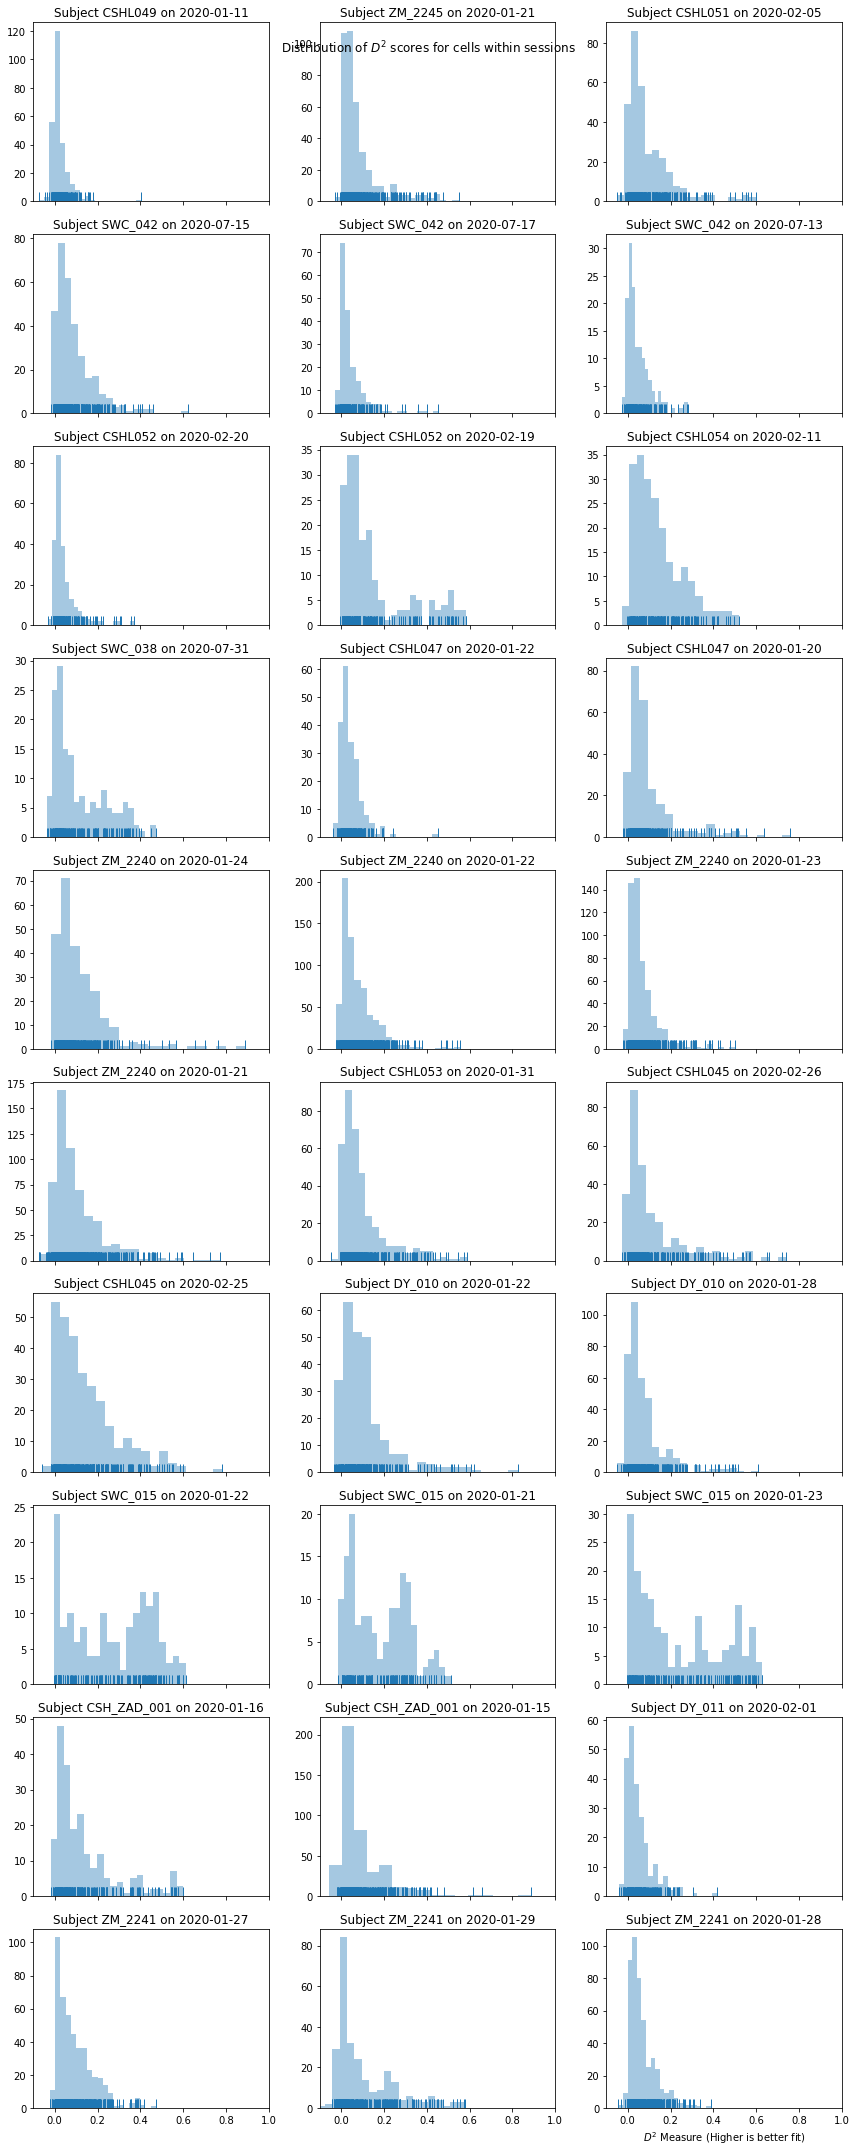

In [28]:
fig, ax = plt.subplots(np.ceil(len(scoredf) / 3).astype(int), 3, figsize=(12, 30), sharex=True)
ax = ax.flatten()
for i, scoreset in scoredf.iterrows():
    sns.distplot(scoreset.fitscores, bins=20, ax=ax[i], rug=True, kde=False)
    ax[i].set_title(f'Subject {scoreset.subject} on {scoreset.sessdate}')
ax[-1].set_xlabel('$D^2$ Measure (Higher is better fit)')
ax[-1].set_xlim([-0.1, 1])
plt.suptitle('Distribution of $D^2$ scores for cells within sessions')
plt.tight_layout()


Text(0.5, 1.0, 'Distribution of $R^2$ for P(Left) and Pstrack')

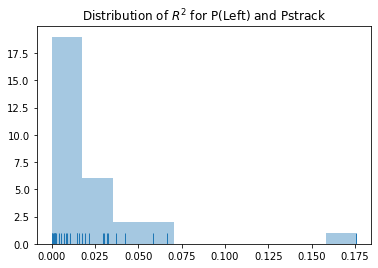

In [37]:
psytrack_corrs = {}
for filename in filedata:
    trialsdf = filedata[filename]['fitobj'].trialsdf
    psytrack_corrs[filename] = np.corrcoef(trialsdf['bias'] - trialsdf['bias'].mean(), trialsdf['probabilityLeft'])[0, 1]
sns.distplot(np.array(list(psytrack_corrs.values()))**2, rug=True, kde=False)
plt.title('Distribution of $R^2$ for P(Left) and Pstrack')

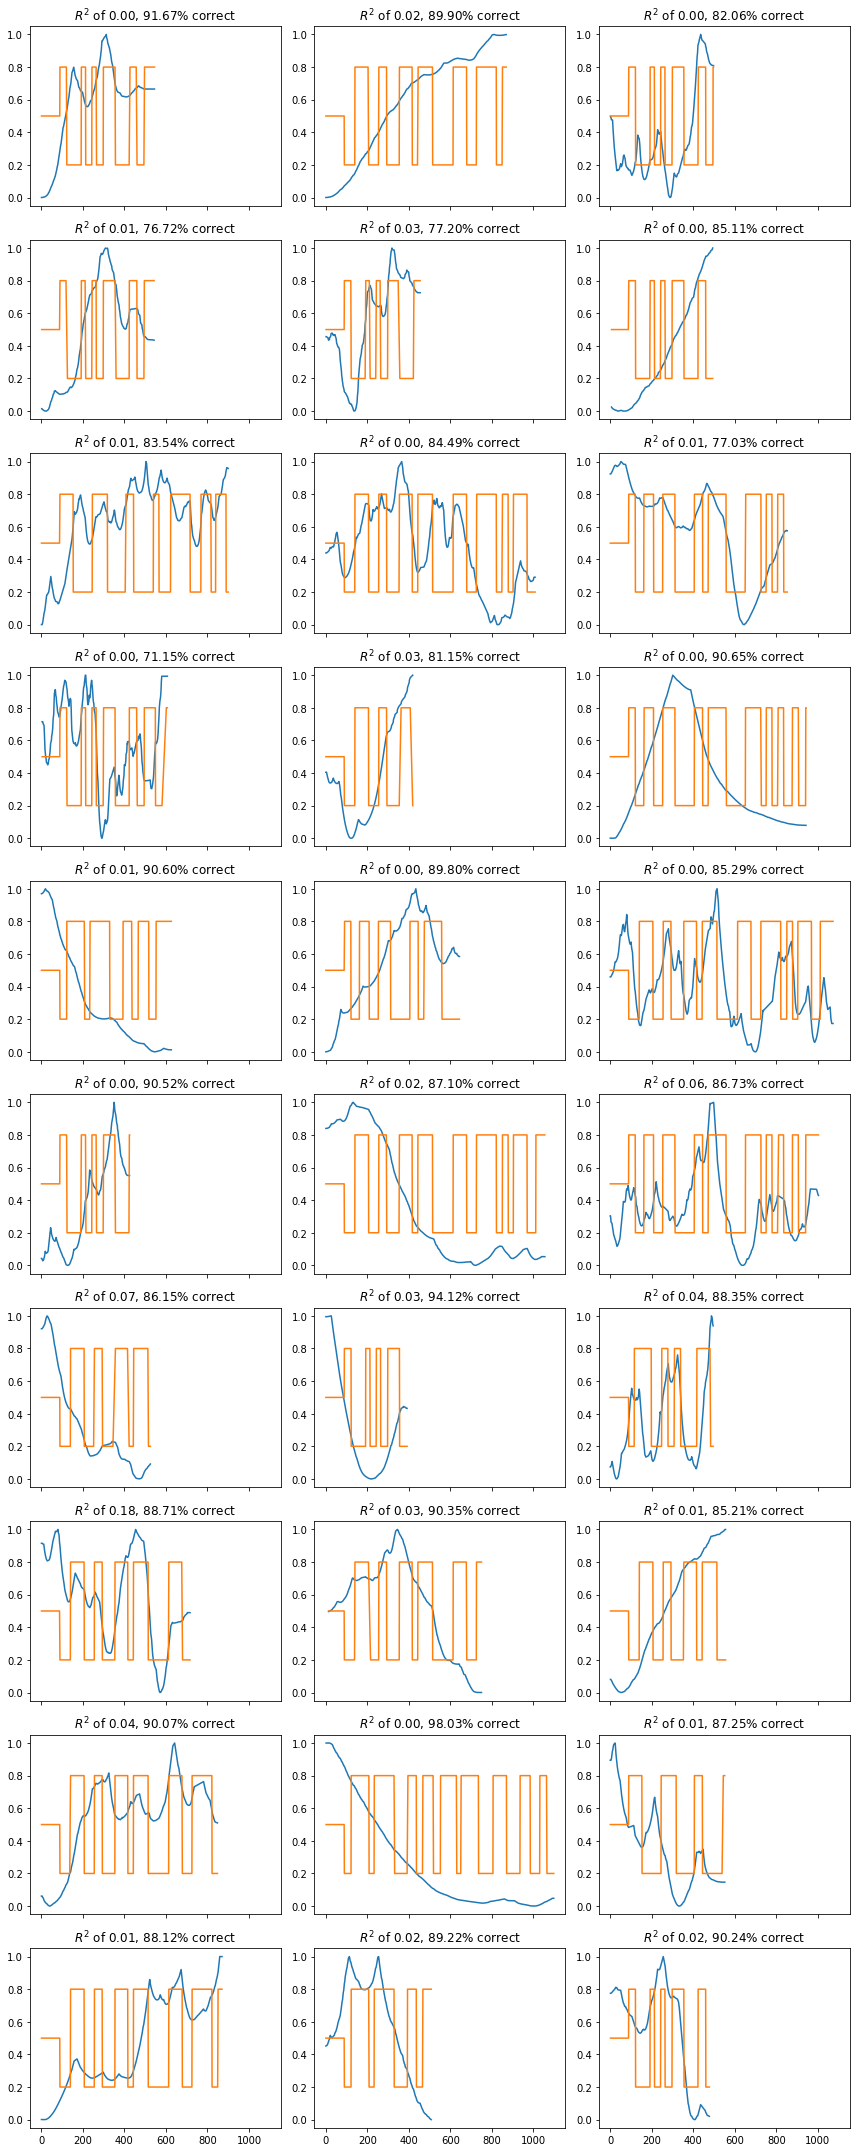

In [49]:
fig, ax = plt.subplots(np.ceil(len(scoredf) / 3).astype(int), 3, figsize=(12, 30), sharex=True)
ax = ax.flatten()
for i, (filename, fitdata) in enumerate(filedata.items()):
    trialsdf = fitdata['fitobj'].trialsdf
    corrval = np.corrcoef(trialsdf.bias - trialsdf.bias.mean(), trialsdf.probabilityLeft)[0, 1]**2
    perc_corr = np.sum(trialsdf.feedbackType == 1) / len(trialsdf)
    meansub = trialsdf.bias - trialsdf.bias.mean()
    shift_rescale = (meansub - meansub.min()) / (meansub - meansub.min()).max()
    ax[i].plot(shift_rescale, label='Psytrack estimate')
    ax[i].plot(trialsdf.probabilityLeft, label='P(Left)')
    ax[i].set_title(f'$R^2$ of {corrval:0.2f}, {perc_corr * 100:0.02f}% correct')
plt.tight_layout()

In [46]:
np.sum(trialsdf.feedbackType == 1) / len(trialsdf)

0.9024390243902439